In [1]:
%%capture
import os
import datetime
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.feature as cfeature
from cycler import cycler
from matplotlib.lines import Line2D
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [7]:
class Map_Plot(object):
    def __init__(self,time_from):
        self.clon = 180
        self.time_from = time_from
        self.proj = ccrs.PlateCarree(central_longitude=self.clon)
        self.fig, self.ax = plt.subplots(subplot_kw=dict(projection=self.proj),figsize=(10,10))
        self.ax.set_xticks(np.arange(0,360,5), crs=ccrs.PlateCarree())
        self.ax.set_yticks(np.arange(-90,90,2.5), crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        self.ax.xaxis.set_major_formatter(lon_formatter)
        self.ax.yaxis.set_major_formatter(lat_formatter)
        # self.ax.set_extent([-60, 120, -25, 25], crs=self.proj)
        self.ax.set_extent([83, 105, -7, 7], crs=self.proj)
        # self.ax.gridlines(draw_labels=False, ylocs=[-0.5,0.5])
        self.plot_rectangles([-0.5,-1,-2])
        self.plot_features()
        # self.ax.coastlines(resolution='50m')
        #self.ax.set(title='Argo Profilers trajectory from {} to {}'.format(time_from,datetime.date.today()))
        self.ax.set(title='ARGO Profilers deployed by IMARPE from 07-03-2016 to 23-03-2016')

    def plot_rectangles(self, lats):
        colors = ['blue', 'red', 'orange']
        for lat, c in zip(lats, colors):
            self.ax.add_patch(mpatches.Rectangle(xy=[120, lat],
                                    width=210,
                                    height=int(abs(lat*2)),
                                    color=c,
                                    alpha=0.3,
                                    transform=ccrs.PlateCarree()))

    def plot_features(self):
        hq_land = cfeature.NaturalEarthFeature(
                            category='physical',
                            name='land',
                            scale='50m',
                            facecolor=cfeature.COLORS['land'])
        hq_border = cfeature.NaturalEarthFeature(
                            category='cultural',
                            name='admin_0_countries',
                            scale='50m',
                            facecolor='none',
                            edgecolor='black')
        self.ax.add_feature(hq_land)
        self.ax.add_feature(hq_border)

    def plot(self, lat, lon, st, name):
        lon = np.where(lon<0, lon+180, lon-180)
        p = self.ax.plot(lon, lat, transform=self.proj,
                        ls='-', lw=1, label='{}({})'.format(name,st))
        if st == 'a':
            self.ax.plot(lon[-1], lat[-1], 's', c=p[0].get_c(),
                        transform=self.proj, ms=4)
        else:
            self.ax.plot(lon[-1], lat[-1], 'o', c=p[0].get_c(),
                        transform=self.proj, markeredgecolor='black',
                        markeredgewidth=1,ms=4)
        self.ax.plot(lon[0], lat[0], 'v', c=p[0].get_c(), markeredgecolor='red',
                        markeredgewidth=1, transform=self.proj, ms=6)
        # if latn is not False:
        #     lonn = np.where(lonn<0, lonn+180, lonn-180)
        #     self.ax.plot(lonn, latn,'o', c='r',ls=':',lw=1.3, ms=2.5)
    
    def show(self):
        plt.gca().add_artist(plt.legend(loc=3, title='Platform number'))
        mstyle = ['v','s','o']
        lines = [Line2D([0], [0], color='black', linewidth=0, marker=ms) for ms in mstyle]
        labels = ['First Deployed', 'Last Seen', 'Inactive']
        plt.legend(lines, labels, loc = 2, title='Status')
        # self.fig.savefig('test.png',dpi=400)

In [8]:
## taken from https://stackoverflow.com/a/16562028
def reject_outliers(data, m = 4.): 
    d = np.abs(data - np.median(data)) 
    mdev = np.median(d) 
    s = d/mdev if mdev else 0. 
    return data[s<m], s<m


def get_status(xdata):
    last_date = xdata.JULD_LAST_LOCATION[-1].data
    today = np.datetime64(datetime.date.today())
    time_d = today - last_date
    if time_d < np.timedelta64(20,'D'):
        return 'a'
    else:
        return 'i'


def extract_data(files,tdelta):
    data_file = xr.open_dataset(files)
    mask = data_file.JULD>tdelta
    # mask_nov = data_file.JULD[mask]<np.datetime64(datetime.datetime(2018,11,4))
    
    lats = data_file.LATITUDE[mask]
    lons = data_file.LONGITUDE[mask]
    
    # latn = lats[mask_nov]
    # lonn = lons[mask_nov]

    lats = lats.data[~np.isnan(lats)]
    lons = lons.data[~np.isnan(lons)]
    
    if lats.size != 0:
        status = get_status(data_file)
        lats, m = reject_outliers(lats)
        lons = lons[m]
        # latn = latn[~np.isnan(latn)]
        # if latn.size != 0:
        #     mask2 = (latn>-0.5)&(latn<0.5)
        #     latn = latn[mask2]
        #     lonn = lonn[~np.isnan(lonn)]
        #     lonn = lonn[mask2]
        #     return lats, lons, latn, lonn
        # else:
        if '3901267' in files:
            lats=lats[1:]
            lons=lons[1:]
        return lats, lons, status
    else:
        return False, False, False

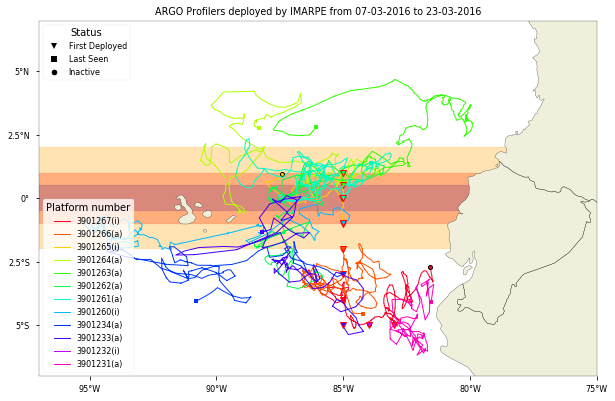

In [9]:
TRAJ_DIR = '/data/users/grivera/ARGO-traj'
template = '{}_Rtraj.nc'
prof_list = np.loadtxt('../Output/peru_argo.txt',dtype=int)
traj_files = [os.path.join(TRAJ_DIR,template.format(x))
                for x in prof_list]
tdelta = np.datetime64(datetime.date.today()-datetime.timedelta(days=1200))
test = Map_Plot(tdelta)

cmap = plt.cm.gist_rainbow
c = cycler('color', cmap(np.linspace(0,1,len(traj_files))) )
plt.rcParams["axes.prop_cycle"] = c
plt.style.use('seaborn-paper')


for trajs,names in zip(traj_files,prof_list):
    try:
        lats, lons, st = extract_data(trajs,tdelta)
        if lats is not False:
            test.plot(lats, lons, st, names)
    except:
        print("Error found in file {}".format(trajs))
        continue
test.show()